## Predict depth to groundwater in aquifer

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [3]:
## Load file
df = pd.read_csv("../acea-water-prediction/Aquifer_Petrignano.csv")
df.tail()

## set index to the date
df["Date"] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
#df = df.set_index("Date")

## according to the description of the data the depth to groundwater is affected by the following variables
## [rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river] 
## we will drop other columns

df = df.drop(columns = ["Depth_to_Groundwater_P24","Temperature_Petrignano"])

print(df.shape)

##rename columns
df = df.rename(columns= {'Rainfall_Bastia_Umbra':'Rainfall',
                   'Depth_to_Groundwater_P25':'Depth_to_groundwater',
                   'Temperature_Bastia_Umbra':'Temperature',
                   'Volume_C10_Petrignano':'Drainage_Volume',
                   'Hydrometry_Fiume_Chiascio_Petrignano':'Hydrometry'})

print(df.columns)

df.head()

(5223, 6)
Index(['Date', 'Rainfall', 'Depth_to_groundwater', 'Temperature',
       'Drainage_Volume', 'Hydrometry'],
      dtype='object')


,Date,Rainfall,Depth_to_groundwater,Temperature,Drainage_Volume,Hydrometry
0,2006-03-14,NaN,-22.18,NaN,NaN,NaN
1,2006-03-15,NaN,-22.14,NaN,NaN,NaN
2,2006-03-16,NaN,-22.04,NaN,NaN,NaN
3,2006-03-17,NaN,-22.04,NaN,NaN,NaN
4,2006-03-18,NaN,-22.04,NaN,NaN,NaN


## Data quality
- Many nan values before 2009
- Manageable number of nan values from 2009 onwards
- drop all data before 2009

In [4]:
df = df[df.Rainfall.notna()]
df = df.reset_index(drop=True)

## Features & Target plot

In [5]:
df.columns

Index(['Date', 'Rainfall', 'Depth_to_groundwater', 'Temperature',
       'Drainage_Volume', 'Hydrometry'],
      dtype='object')

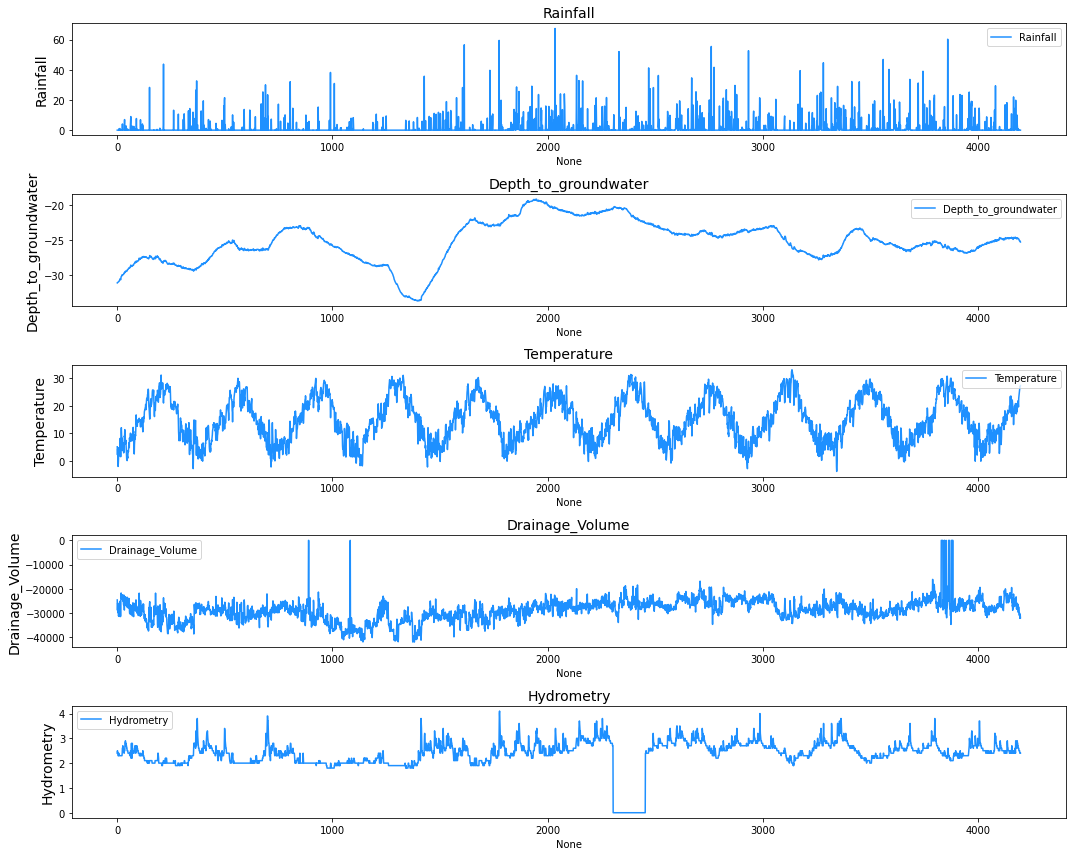

In [6]:
fig, ax = plt.subplots(5,1, figsize=(15,12))

for num,col in enumerate(df.columns[1:]):
    sns.lineplot(x=df.index, y=df[col].fillna(np.inf), ax=ax[num], color='dodgerblue',label=col)
    ax[num].set_title(col, fontsize=14)
    ax[num].set_ylabel(ylabel=col, fontsize=14)
plt.tight_layout()


## Cleaning data
- There are zero values in Drainage volume & hydrometry that should definitely not be zero

In [8]:
change_cols = ["Hydrometry","Drainage_Volume"]

for col in change_cols:
    df.loc[df[col] == 0, col] = np.nan

## show missing values

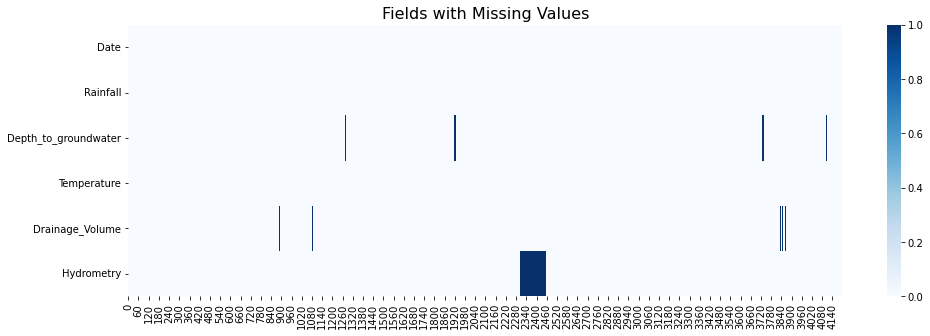

In [9]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)

plt.show()

## Missing values (4 approaches)
- set to 0 (or some other fixed value)
- set to the mean
- set to previous real value
- Linear interpolation

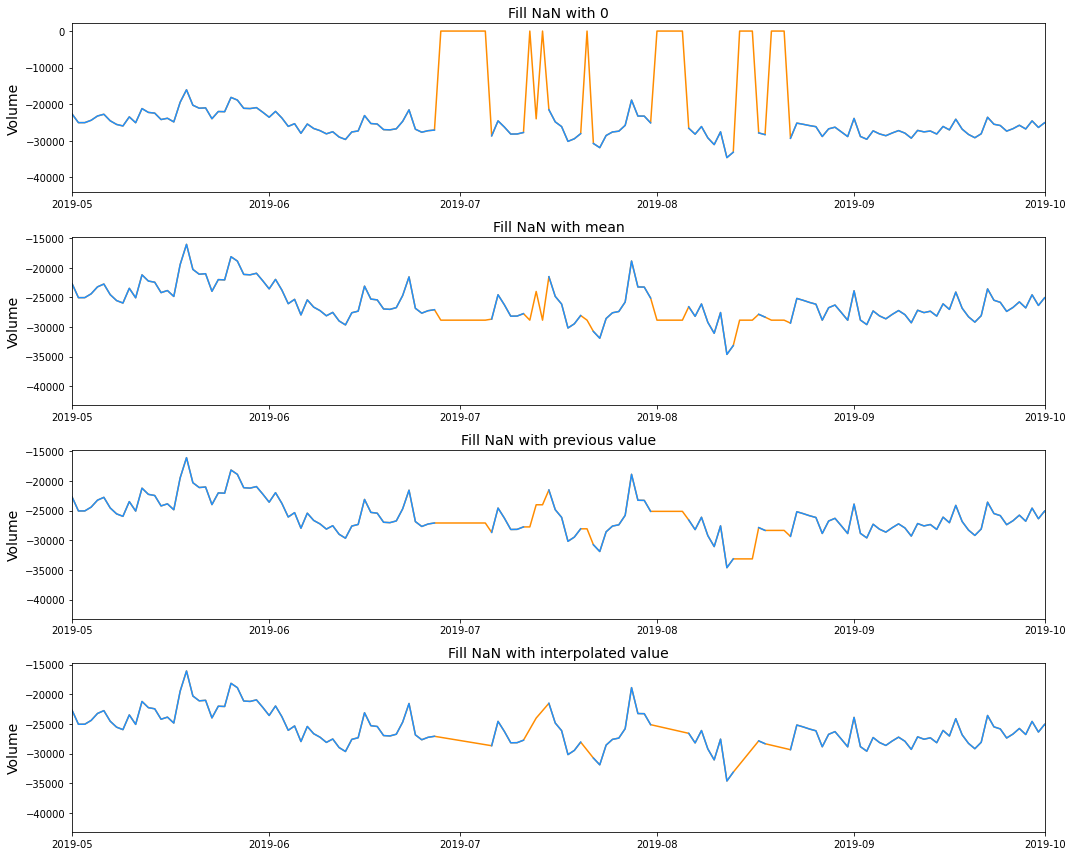

In [10]:
from datetime import datetime, date 

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

#### change to zero
ax[0].plot(df["Date"], df["Drainage_Volume"].fillna(0),color='darkorange', label = 'modified')
ax[0].plot(df["Date"], df["Drainage_Volume"], color='dodgerblue', label = 'original')

ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume', fontsize=14)

#### change to mean
ax[1].plot(df["Date"], df["Drainage_Volume"].fillna(df["Drainage_Volume"].mean()),color='darkorange', label = 'modified')
ax[1].plot(df["Date"], df["Drainage_Volume"], color='dodgerblue', label = 'original')

ax[1].set_title('Fill NaN with mean', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)

#### change to zero
ax[2].plot(df["Date"], df["Drainage_Volume"].ffill(),color='darkorange', label = 'modified')
ax[2].plot(df["Date"], df["Drainage_Volume"], color='dodgerblue', label = 'original')

ax[2].set_title('Fill NaN with previous value', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

#### change to zero
ax[3].plot(df["Date"], df["Drainage_Volume"].interpolate(),color='darkorange', label = 'modified')
ax[3].plot(df["Date"], df["Drainage_Volume"], color='dodgerblue', label = 'original')

ax[3].set_title('Fill NaN with interpolated value', fontsize=14)
ax[3].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [11]:
## Interpolate all  values
for col in df.columns:
    df[col] = df[col].interpolate()

## Resampling to weekly data

In [12]:
## Downsampling to weekly
df_downsampled = df[['Date',
                     'Depth_to_groundwater', 
                     'Temperature',
                     'Drainage_Volume', 
                     'Hydrometry'
                    ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df_downsampled.tail()

,Date,Depth_to_groundwater,Temperature,Drainage_Volume,Hydrometry,Rainfall
595,2020-05-28,-24.697143,17.214286,-25591.062857,2.414286,24.6
596,2020-06-04,-24.638571,18.785714,-24567.099429,2.628571,46.2
597,2020-06-11,-24.751429,19.200000,-27178.416000,2.771429,20.0
598,2020-06-18,-24.822857,21.942857,-28030.134857,2.600000,1.4
599,2020-06-25,-25.145000,26.383333,-31131.504000,2.433333,0.0


## Check for stationarity
- Requirement for certain statistical models
    - ARIMA/SARIMA
- Can speed up training of Deep learning models forecasting/prediction
    - LSTM
    
- Use statsmodels ADF or KPSS test


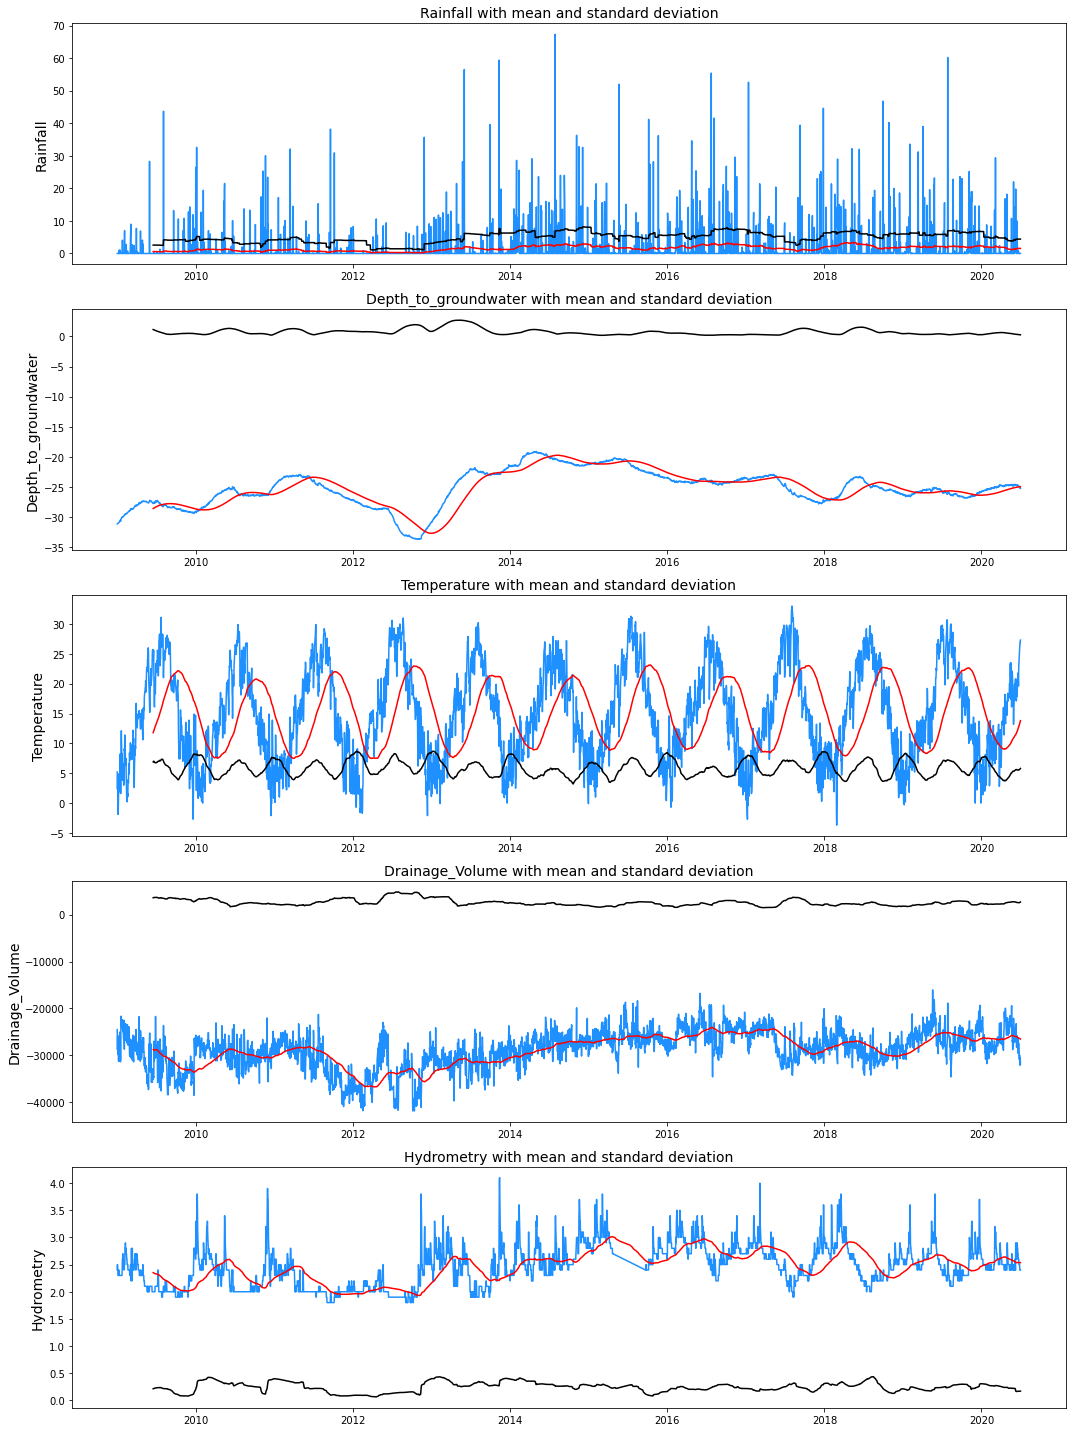

In [13]:
## Check rolling mean and rolling Std for features

from datetime import datetime, date 

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

## num hours per week
window_size = 168

#### change to zero
for num, col in enumerate(df.columns[1:]):
    ax[num].plot(df["Date"], df[col].fillna(0),color='dodgerblue', label = 'modified')
    ax[num].plot(df["Date"], df[col].rolling(window_size).std(), color='black', label = 'original')
    ax[num].plot(df["Date"], df[col].rolling(window_size).mean(), color='red', label = 'original')


    ax[num].set_title(f'{col} with mean and standard deviation', fontsize=14)
    ax[num].set_ylabel(ylabel=col, fontsize=14)
    
plt.tight_layout()
plt.show()

## What is the distribution of each variable?

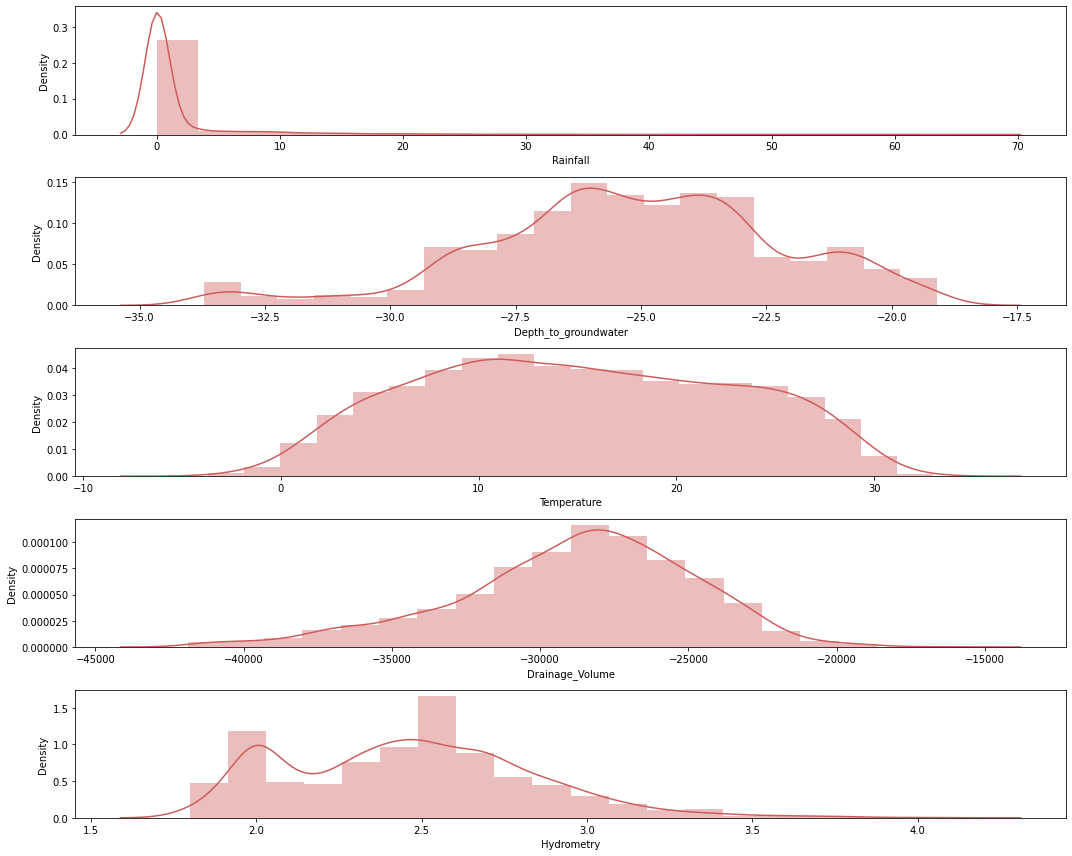

In [14]:
## Check rolling mean and rolling Std for features

from datetime import datetime, date 

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))

## num hours per week
window_size = 168

#### change to zero
for num, col in enumerate(df.columns[1:]):
    sns.distplot(df[col], ax=ax[num], color='indianred',bins = 20)
#     ax[num].plot(df["Date"], df[col].fillna(0),color='dodgerblue', label = 'modified')
#     ax[num].plot(df["Date"], df[col].rolling(window_size).std(), color='black', label = 'original')
#     ax[num].plot(df["Date"], df[col].rolling(window_size).mean(), color='red', label = 'original')


#     ax[num].set_title(f'{col} with mean and standard deviation', fontsize=14)
#     ax[num].set_ylabel(ylabel=col, fontsize=14)
    
plt.tight_layout()
plt.show()

## Run stationarity test

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

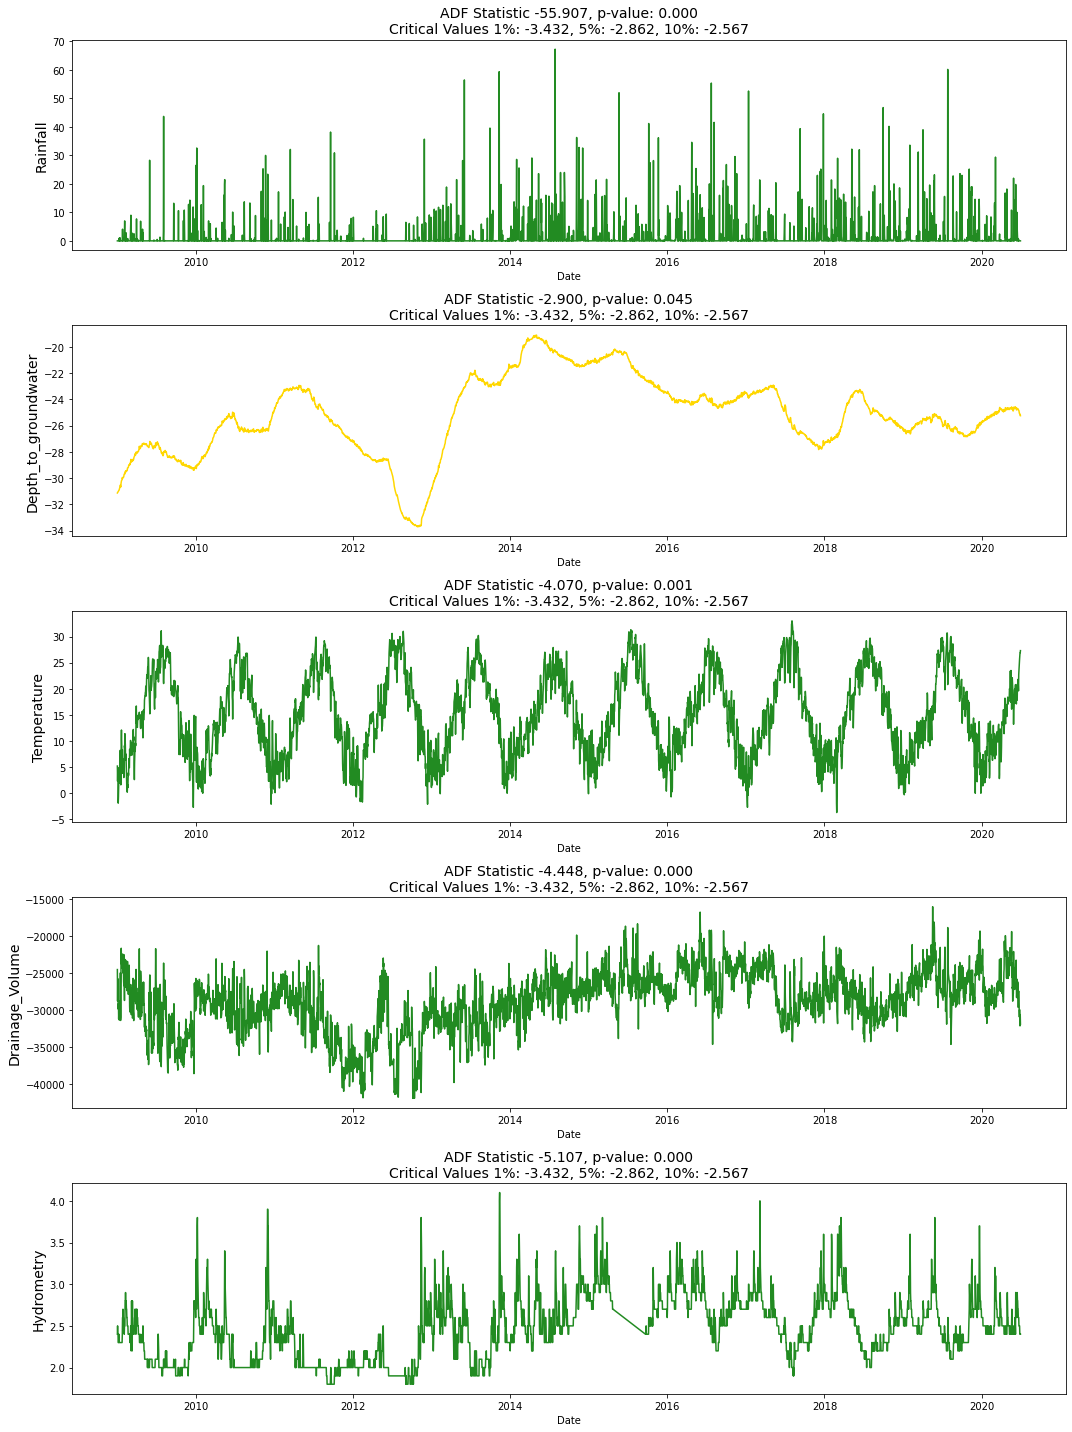

In [16]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))


def visualize_adfuller_results(df, series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.Date, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

for num, col in enumerate(df.columns[1:]):
    visualize_adfuller_results(df, df[col], col, ax[num])

plt.tight_layout()
plt.show()

## Depth to groundwater is weakly stationary
- make more stationary with differencing

In [17]:
# First Order Differencing
diff = np.diff(df.Depth_to_groundwater)
df['Depth_to_groundwater_diff_1'] = np.append([0], diff)

# Second Order Differencing
diff = np.diff(df.Depth_to_groundwater_diff_1)
df['Depth_to_groundwater_diff_2'] = np.append([0], diff)

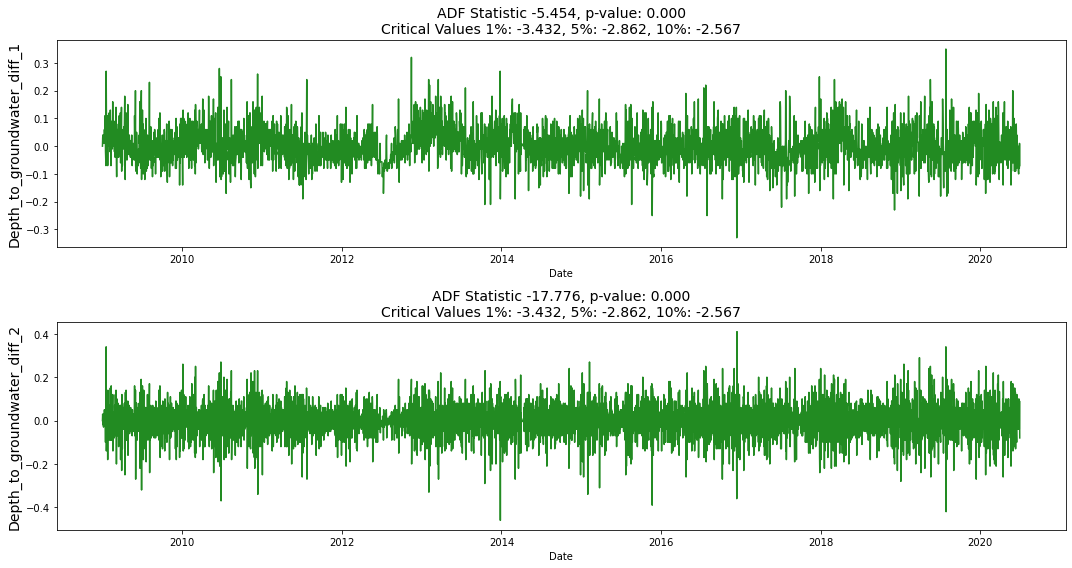

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

for num, col in enumerate(['Depth_to_groundwater_diff_1','Depth_to_groundwater_diff_2']):
    visualize_adfuller_results(df, df[col], col, ax[num])

plt.tight_layout()
plt.show()

## Encoding cyclical features

In [19]:
#encode day and month as cyclical features
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df["Day"] = pd.DatetimeIndex(df["Date"]).dayofyear.astype(int)
df["Day"] = df["Day"].clip(0,365)

num_months = 12
df['Month_sin'] = np.sin(2*np.pi*df["Month"]/num_months)
df['Month_cos'] = np.cos(2*np.pi*df["Month"]/num_months)

num_days = 365
df['Day_sin'] = np.sin(2*np.pi*df["Day"]/num_days)
df['Day_cos'] = np.cos(2*np.pi*df["Day"]/num_days)


## Time series decomposition

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_cols =  ['Rainfall', 'Temperature', 
                   'Drainage_Volume', 
                   'Hydrometry', 'Depth_to_groundwater',
                  'Depth_to_groundwater',
                  'Depth_to_groundwater_diff_1',
                  'Depth_to_groundwater_diff_2']

for col in decompose_cols:
    decomp = seasonal_decompose(df[col], period = 365, model='additive', extrapolate_trend='freq')
    df[f"{col}_trend"] = decomp.trend
    df[f"{col}_seasonal"] = decomp.seasonal
    df[f"{col}_res"] = decomp.resid

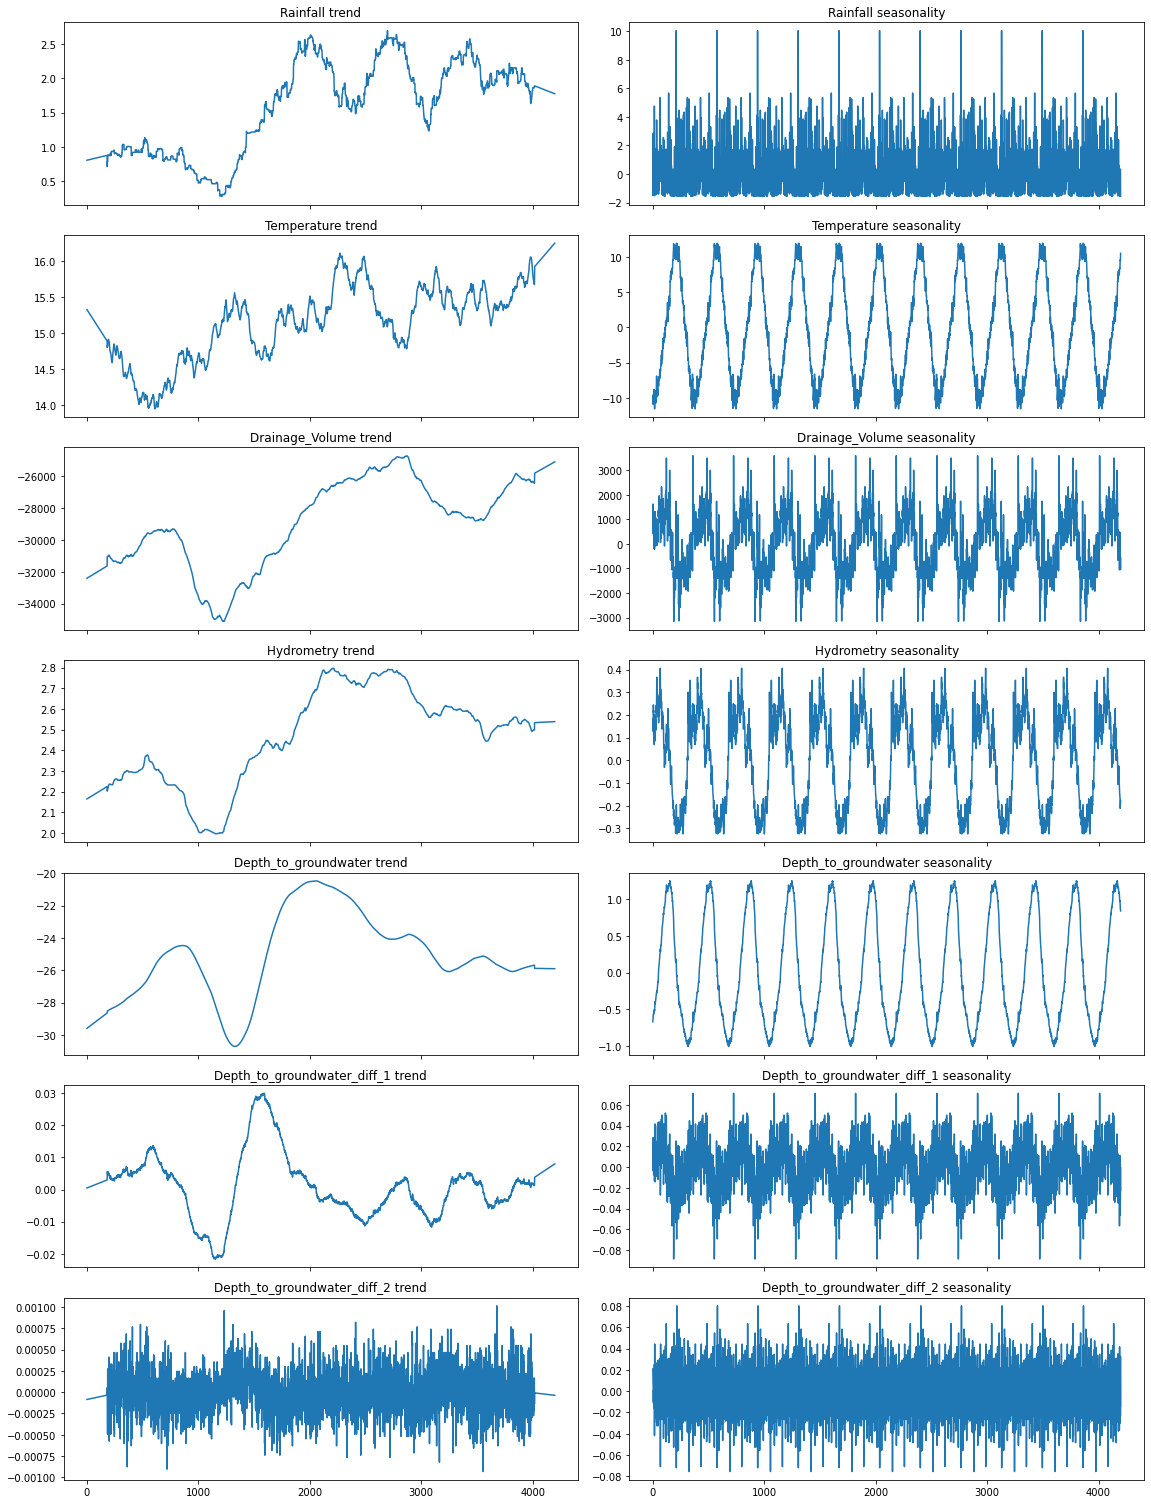

In [21]:
fig, ax = plt.subplots(7, 2, sharex=True, figsize=(16,21))

decompose_cols =  ['Rainfall', 
                   'Temperature', 
                   'Drainage_Volume', 
                   'Hydrometry', 
                   'Depth_to_groundwater',
                  'Depth_to_groundwater_diff_1',
                  'Depth_to_groundwater_diff_2']

for num, col in enumerate(decompose_cols):
    ax[num,0].plot(df[f"{col}_trend"])
    ax[num,1].plot(df[f"{col}_seasonal"])
    
    ax[num,0].set_title(f"{col} trend")
    ax[num,1].set_title(f"{col} seasonality")

plt.tight_layout()

## Find Seasonality of Depth to griundwater diff 2 with ACF PACF plot
- No clear seasonality

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

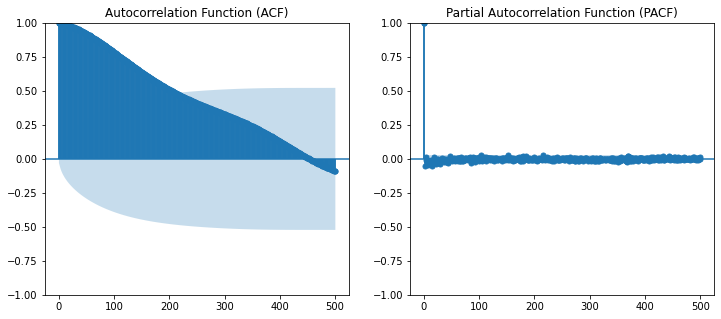

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(df.Depth_to_groundwater, lags=500, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Partial Autocorrelation Function (PACF)
plot_pacf(df.Depth_to_groundwater, lags=500, ax=axes[1], method='ywm')  
axes[1].set_title("Partial Autocorrelation Function (PACF)")


## Split data

In [62]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 5

X = df.Date
y = df.Depth_to_groundwater_diff_2

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [63]:
X

0      2009-01-01
1      2009-01-02
2      2009-01-03
3      2009-01-04
4      2009-01-05
          ...    
4194   2020-06-26
4195   2020-06-27
4196   2020-06-28
4197   2020-06-29
4198   2020-06-30
Name: Date, Length: 4199, dtype: datetime64[ns]

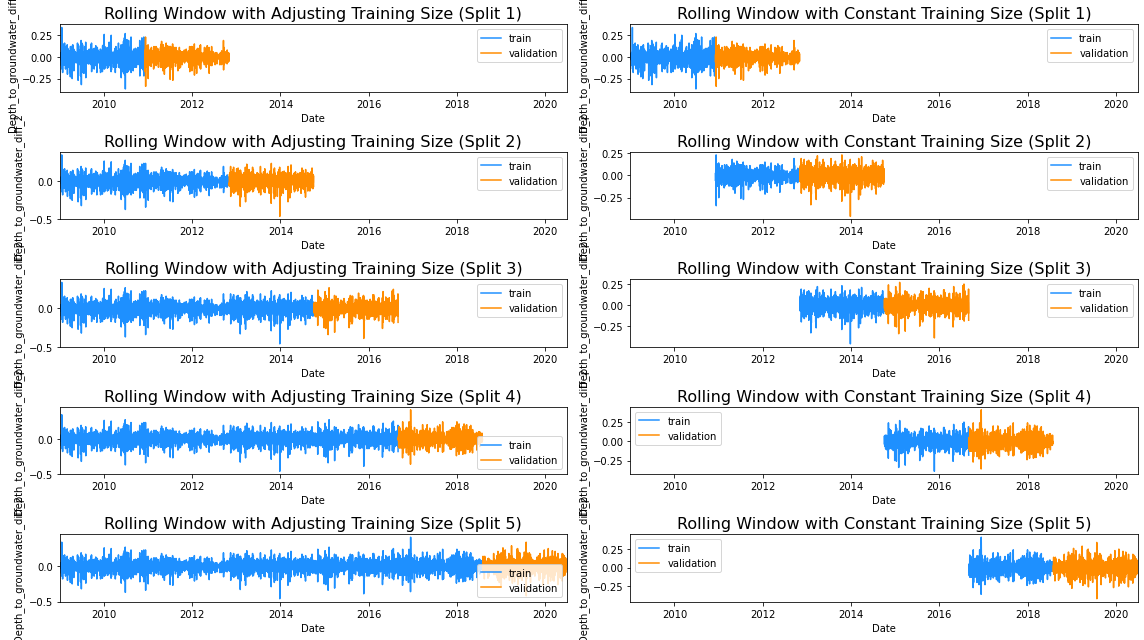

In [70]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.tight_layout()
plt.show()

In [23]:
df.to_csv("../Processed_data/processed_data.csv")